## **0 - Introduction**

_In this notebook, we introduce the problem at hand, exploration our data, train classifiers, and evaluate their performance. We expect that you have followed all initial setup instructions within the README.md to run this notebook. Note that we do not perform the actual training in this notebook as it would be unreasonable to expect you to have a GPU. For this reason, we explain the training code and simply refer to the fully trained models when gauging performance._

**Set-up:**

If you are seeing this notebook for the first time and would like to run it, please follow these steps. Note that you will need several (>9) GB of free space in order to succesfully do the following:

1) In the same directory where this notebook is currently located on your device, make a new folder called "data\".

2) Visit this [page on Kaggle](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) and download the dataset.

3) Extract the data from the compressed file into the "data\" folder, such that your current directory mirrors the following (thank you for helping me generate this figure ChatGPT):

```
root_directory
   |- exploratory_analysis.ipynb
   |- data
      |- asl_alphabet_test
         |- data...
      |- asl_alphabet_train
         |- data...
```

4) Setup your environment as specified in the README.md

**Problem and Goal Outline:**

American Sign Language (ASL) is a sign language (SL) used by nearly half a million people in the U.S., and is primarily used by individuals within the deaf community, and those with difficulty hearing ([RI.gov](https://cdhh.ri.gov/information-referral/american-sign-language.php)). SLs are unique languages of uncertain origin with their own unique sentence structures and sets of rules, even having a wide diversity of dialects - like any language ([N.I.H.](https://www.nidcd.nih.gov/health/american-sign-language)). Unfortunately, with the lack of universality of sign languages (British sign language vs ASL for example) and the severe lack of support for SLs, access to services like healthcare can prove to be near impossible in many places ([B.U. School of Public Health](https://www.bu.edu/sph/news/articles/2018/healthcare-language-barriers-affect-deaf-people-too/)). Thus, there is a need for a greater number of tools and services for SL interpretation.

In this project, we aim to leverage machine learning classification to develop tools for aiding in interpreting the ASL alphabet, our target variable being the predicted letter. We use [Kaggle’s ASL alphabet dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) for this purpose. This dataset consists of over 87,000 images. With 3000 images for each of the 26 letters, “delete”, “space”, and “nothing”, we hope to apply deep learning techniques for multi-class image classification. Note in the context of this problem there are no missing values. 

Additionally, we perform hand-object detection to help in applying our ASL alphabet classification model for live-inference to improve localization (by using a bounding box), and to ensure our tool’s robustness to occlusions and background noise. We work with tensorflow and models with possibly some degree of pretraining (such as VGG or ResNet) as well as a simple convolutional models. Note that we have access to several GPUs (RTX a6000, RTX a5000 on a high-performance computer, as well as an RTX 3080 on laptop). 

## **1 - Load Libraries**

In [54]:
# forgive me for using type ignore and filter warnings. I know it's not the best practice but everything still works and the warnings are annoying.
import warnings
warnings.filterwarnings('ignore')

# generic imports
import os
import random
import json
import warnings

# numpy
import numpy as np # type: ignore
from numpy import expand_dims # type: ignore
from numpy.random import seed # type: ignore

# visualization
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import cv2 # type: ignore

# tensorflow
import tensorflow as tf # type: ignore
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.layers.experimental.preprocessing import Rescaling # type: ignore

# sklearn
import sklearn # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import confusion_matrix # type: ignore

# keras
from keras.applications.vgg16 import preprocess_input # type: ignore
from keras.models import Model # type: ignore

# custom imports
from model.simpleModel import ConvNet3
from model.vgg import Vgg16

## **2 - Setup and Preprocessing**

In [55]:
# The directory where the data is stored. Training and testing, respectively.
train_data = './data/asl_alphabet_train/asl_alphabet_train/'
test_data = './data/asl_alphabet_test/asl_alphabet_test/'

We use tensorflow's ImageDataGenerator to take all of our data in the data folder and turn it into a Dataset object. This will permit efficient referencing of data instances through batching.

**NOTE**: feel free to select which model to load in the following cell.

In [56]:
# The paths to the model weights we think are worthy of exploring:
convnet3 = os.path.join('temp', 'convnet3_adam_categorical_crossentropy_lr0.001_mo9e-06_rs9964', 'convnet3.h5')
vgg = os.path.join('temp', 'vgg_adam_categorical_crossentropy_lr0.001_mo9e-06_rs132', 'vgg.h5')
vgg_best = os.path.join('temp', 'vgg_adam_categorical_crossentropy_lr0.0001_mo9e-06_rs150', 'vgg.h5')

# NOTE: FEEL FREE TO CHANGE THIS TO TEST OTHER MODELS (see options above)
test_model = vgg_best

batch_size = 32

if test_model == convnet3:
    img_size = (64, 64)
    color = 'rgb'
    random_seed = 99
    val_split = 0.2
elif test_model == vgg:
    img_size = (32, 32)
    color = 'rgb'
    random_seed = 1
    val_split = 0.2
elif test_model == vgg_best:
    img_size = (50, 50)
    color = 'rgb'
    random_seed = 1
    val_split = 0.2

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
label_map = {i: class_name for i, class_name in enumerate(class_names)}

# Source: https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator. We apply rescaling as our transformation with nearest fill mode. We also 
# perform the corresponding splitting. We then use the image generator to have images flow from the directory in batches according the batck size we specify. We use categorical here
# since all of our training runs so far have used categorical crossentropy (which requires one-hot encoding of the labels). We also specify the subset to be training or validation and the
# seed for greater replicability of the data between train and test runs.
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=val_split,
                             fill_mode='nearest')

train_dataset = datagen.flow_from_directory(train_data,
                                            target_size=img_size,
                                            color_mode=color,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            subset='training',
                                            seed=random_seed)

val_dataset = datagen.flow_from_directory(train_data,
                                            target_size=img_size,
                                            color_mode=color,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            subset='validation',
                                            seed=random_seed)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


## **3 - Data Exploration**

Fantastic! We now have our dataset ready to go! We will now define a few functions that will allow us to work with a and visualize our data before training.

In [57]:
def plotImages(images, labels, n_col=3, n_row=3, seed=42, color='viridis', label_map=None):
    '''
    Function to plot a grid of images. The number of columns and rows can be specified.
    The function will randomly select images from the input dataset and plot them.

    Parameters:
    images (numpy.ndarray): The images to be plotted.
    labels (numpy.ndarray): The labels of the images.
    n_col (int): The number of columns in the grid.
    n_row (int): The number of rows in the grid.
    seed (int): The seed for the random number generator.
    color (str): The color map to be used for the images.
    label_map (dict): A dictionary mapping the labels to their corresponding class names.
    '''
    # if labels are categorical:
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
        
    # Basic safety check to ensure there exist enough images in the batch. Then, get the random indices.
    if n_col * n_row > len(images):
        raise ValueError("The number of columns and rows can not be greater than the number of images.")
    indices = random.choices(range(len(images)), k= n_col * n_row)

    # Create the plot
    random.seed(seed)
    fig, axes = plt.subplots(n_row, n_col, figsize=(13, 13))
    for i in range(n_row):
        for j in range(n_col):
            axes[i, j].imshow(images[indices[i * n_col + j]], cmap=color)
            if label_map is None:
                axes[i, j].set_title(f"Label: {labels[indices[i * n_col + j]]}")
            else:
                axes[i, j].set_title(f"Label: {label_map.get(labels[indices[i * n_col + j]])}")
            axes[i, j].axis('off')
    plt.show()

Let's inspect that the images themselves are correct. It appears that there is a nice balance of images with variable lighting, position, scale (more representative data of an in real life scenario perhaps?). We should make an important point that this set of images comes from what looks like sequential frames in a video. Maybe our dataset is not fully representative of all scenarios out in the world then...

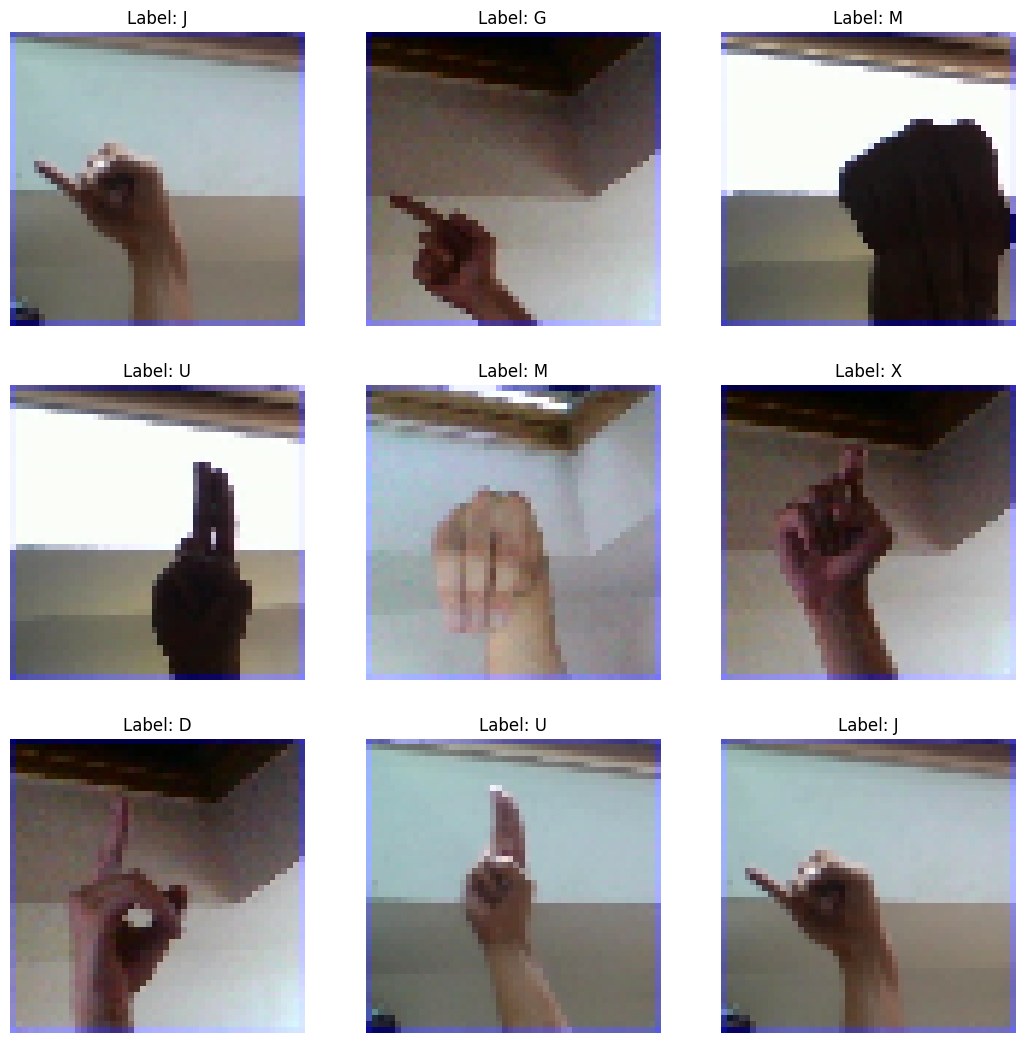

In [58]:
# Get a batch of images from the iterator
images, labels = next(train_dataset)

# Plot the images
plotImages(images, labels, n_col=3, n_row=3, color='viridis', label_map=label_map)

For this next part, we want to check the label distribution. This is purely a hypothetical scenario to test splitting distribution of the data since I couldn't identify a way for the ImageGenerator that doesn't have to iterate through and load all images in a slow manner. Nevertheless, it gives a good idea of what our different training and validation sets might look like.

**NOTE**: we will not be performing test splittings. As of the latest state of the project, we are at a place where we are still comparing models against one-another before deciding which model is best. This is the job for the validation set! Not the testing set! We do have a few additional test images we can use to stress-test our model in bad lighting conditions though....

In [59]:
class ASLDataPaths():
    '''
    fetchASLDataPaths is a class that fetches the paths of the ASL dataset from a directory. The rationale behind such a class
    is the fact that our dataset is huge (relatively speaking), and we can not afford to load the entire dataset of images into memory.
    Rather, it might be a better idea to load the paths of the images, and then load the images in batches as we train our model. 
    '''

    def __init__(self, data_dir: str):

        # Check if the data directory exists
        if type(data_dir) != str or not os.path.exists(data_dir):
            raise FileNotFoundError(f"The directory {data_dir} does not exist.")
        self.data_dir = data_dir

    def fetch_paths(self):
        X_paths = []
        y = []

        # Walk over the data directory and fetch the paths of all images, label in the dataset
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                X_paths.append(os.path.join(root, file))
                y.append(os.path.basename(root))
        
        X_paths = np.array(X_paths)
        y = np.array(y)
        return X_paths, y

Now we can actually perform some hypothetical splittings for our data. It is a good enough approximation of how our splits might look even if we are not actually training on the following ones.

In [60]:
X_path, y = ASLDataPaths(data_dir = train_data).fetch_paths()
X_train_path, X_test_path, y_train, y_test = train_test_split(X_path, y, test_size=val_split, random_state=random_seed, shuffle=True)

As we can see, the distribution of labels for both the training, validation, and testing data appears uniform. Relatively balanced! 

What does this mean for our potential metrics? For one, we have more flexibility:

1) We could use some variation of ROC-AUC adapted for multi-class classification (one vs. all or averaging). Though, we might think about using confusion matrices to understand individual class errors better, and other metrics such as a precision, recall, F1 (averaged).

2) Our dataset is representative of all letters (ignoring such facts that letters such as X, Z are more rarely used).

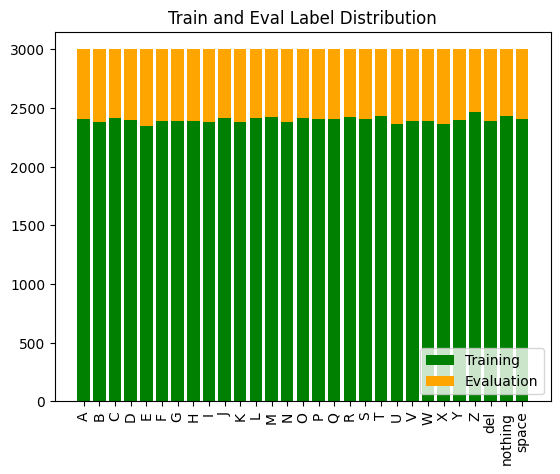

In [61]:
# Let's check how balanced the training dataset is
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

# Plot the distribution of the labels
plt.title('Train and Eval Label Distribution')
plt.bar(unique_labels_train, label_counts_train, color='green')
plt.bar(unique_labels_test, label_counts_test, color='orange', bottom=label_counts_train)

# Other plot parameters
plt.legend(['Training', 'Evaluation'], loc='lower right')
plt.xticks(rotation=90)
plt.show()

## **4 - Training**

In this section we cover the training process of our ASL hand recognition classifier. While you will not be running the actual training yourself in this notebook due to reasonable expectations for how long it should take, we will explain how the training is performed in `train.py`. Additionally, if you would like to try the training yourself, refer to the README to ensure proper setup with GPU, examples of combos of arguments, etc...

### **A. The Training Steps**

First let us start by explaining the way in which the repo is set up to perform training. In the same directory as this notebook you will find a `train.py` file. This script is set up such that you can run it from the command line, passing hyperparameters as arguments (examples which you will find in the README) using argparse. It relies on a number of other modules we wrote under `util/metric.py`, `util/model.py`, `util/directory.py`.

Now, on to explaining whats in `train.py`:

```python
API_KEY = os.environ.get('COMET_API_KEY')

# Initialize Comet experiment
experiment = Experiment(api_key=API_KEY, 
                        project_name="asl",
                        workspace="joeshmoe03",
                        auto_output_logging="default",
                        auto_param_logging = True,
                        auto_metric_logging = True)
```

- [Comet-ml](https://www.comet.com/site/) is a platform that enables us to track metrics and training progress. This is particularly advantageous in contexts of trying to train deep learning models on remote machines with very powerful GPUs. Also, it makes nice figures for us. Here, we just initialized a new experiment to log the progress! 
- Note that we have set our API key as an environment variable for security reasons. If you would like to train, once you [sign up](https://www.comet.com/signup), you can retrieve your key and [set it as your "COMET_API_KEY" environment variable](https://www.twilio.com/en-us/blog/how-to-set-environment-variables-html) and replace "workspace" with your own.

```python

def main(args):
    ...
    # training and testing inside here
    ...
    return

if __name__ == "__main__":
    # Parser for easier running of the script on command line. Can specify hyperparameters and model type this way.  
    parser = argparse.ArgumentParser()
    parser.add_argument('-nepoch'   , type=int  , action="store", dest='nepoch'   , default=10   )
    # number of epochs
    parser.add_argument('-batchSize', type=int  , action="store", dest='batchSize', default=32   )
    # batch size
    parser.add_argument('-lr'       , type=float, action="store", dest='lr'       , default=0.001)
    # learning rate
    parser.add_argument('-resample' , type=int  , action="store", dest='resample' , default=42   )
    # resample data
    parser.add_argument('-momentum' , type=float, action="store", dest='momentum' , default=9e-06  )
    # for momentum SGD and RMSprop
    parser.add_argument('-model'    , type=str  , action="store", dest='model'    , default='resnet')
    # VGG, ResNet, etc...
    parser.add_argument('-optim'    , type=str  , action="store", dest='optim'    , default='adam')
    # SGD, adam, etc...
    parser.add_argument('-loss'     , type=str  , action="store", dest='loss'     , default='categorical_crossentropy')
    parser.add_argument('-val'      , type=float, action="store", dest='valSize'  , default=0.2  )
    # validation percentage
    parser.add_argument('-stopping' , type=int , action="store", dest='earlyStopping', default=3 )
    parser.add_argument('-color'    , type=str  , action="store", dest='color'    , default='rgb')
    # rgb, grayscale 
    parser.add_argument('-img_size' , type=int  , action="store", dest='img_size' , default=64   )
    # image size
    parser.add_argument('-data_dir' , type=str  , action="store", dest='data_dir' , default='./data/asl_alphabet_train/asl_alphabet_train/')
    parser.add_argument('-pretrain' , type=str  , action="store", dest='pretrain' , default=None)
    # use pretrained weights in specific directory
    parser.add_argument('-logits'   , type=bool , action="store", dest='from_logits', default=False) 
    # has softmax been applied for probability? If not, then set to True. See source: https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function 
    parser.add_argument('-metric'   , nargs='+', type=str, action="store", dest='metric', default=['accuracy']) 
    # ['accuracy', 'precision', 'recall', 'f1_score'] NOTE: any other metric than accuracy is broken at the moment for sparse_categorical_crossentropy it appears
    parser.add_argument('-beta1'    , type=float, action="store", dest='beta1', default=0.9) 
    # for Adam optimizer. Does nothing if specified and not using Adam optimizer
    parser.add_argument('-beta2'    , type=float, action="store", dest='beta2', default=0.999) 
    # for Adam optimizer. Does nothing if specified and not using Adam optimizer
    parser.add_argument('-epsilon'  , type=float, action="store", dest='epsilon', default=1e-07) 
    # for Adam optimizer. Does nothing if specified and not using Adam optimizer
    parser.add_argument('-nest'     , type=bool, action="store", dest='nesterov', default=False) 
    # for SGD optimizer. Does nothing if specified and not using SGD optimizer
    args = parser.parse_args()
    main(args)

```

`main` represents the entry point for which we can pass a number of hyperparameters for training (`lr` for learning rate, `nepoch` for number of epochs, etc...) with [argparse](https://docs.python.org/3/library/argparse.html). We provide default arguments so that we are not required to pass everything. This is perhaps a more adaptable approach that enables us to recycle the format of our training script for future ML problems!

Inside of `main` we have:

```python
    # We save training runs and their associated sampling of data in the /temp/ 
    # directory under a folder named according to the sampling and hyperparameters.
    scratch_dir = initScratchDir(args)

# Source: https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator. We apply rescaling as our transformation with nearest fill mode. We also perform the corresponding splitting. We then use the image generator to have images flow from the directory in batches according the batck size we specify. We use categorical here since all of our training runs so far have used categorical crossentropy (which requires one-hot encoding of the labels). We also specify the subset to be training or validation and the seed for greater replicability of the data between train and test runs.
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=args.valSize,
                                 fill_mode='nearest')

    train_dataset = datagen.flow_from_directory(args.data_dir,
                                                target_size=(args.img_size, args.img_size),
                                                color_mode=args.color,
                                                batch_size=args.batchSize,
                                                class_mode='categorical' if args.loss == 'categorical_crossentropy' else 'sparse',
                                                subset='training',
                                                seed=args.resample)

    val_dataset = datagen.flow_from_directory(args.data_dir,
                                                target_size=(args.img_size, args.img_size),
                                                color_mode=args.color,
                                                batch_size=args.batchSize,
                                                class_mode='categorical' if args.loss == 'categorical_crossentropy' else 'sparse',
                                                subset='validation',
                                                seed=args.resample)
```

Here we use a function under `util/directory.py` to initialize a directory named according to the training run hyperparameters, where we save the outcome of our training process. This allows us to compare models and metrics after the fact for greater reproducibility!

1) We use an ImageDataGenerator as it works with the standardized file structure of our dataset. We simply pass the hyperparameters that specify how we want the data to look for training. Note that we don't naively load the entirety of the dataset into memory all at once, as it is nearly 9-10 GB in size - too much! Instead we rely on the specification of a `arg.batchSize` to make more realistic usage of memory.

2) We also encode labels on the basis of loss functions. Loss functions like `"sparse_categorical_crossentropy"` may require a single column of labels whereas `"categorical_crossentropy"` requires one-hot encoding of labels. For our particular task of multiclass classification, we need a loss function to calculate cross entropy between a probabilities of a predicted class and a target such that the sample falls in only one of several categories. It is computed as the negative sum over classes of targets * the log of the outputted probability. 

3) We then perform the splittings based on the specified arguments or defaults. 

4) We also use resizing, and rescaling. Interestingly in the context of this particular classification problem, flipping and rotations are terrible transformation ideas. As it turns out, the orientation of the hand is very important in discerning distinct letters in the ASL alphabet. For 
example, a slightly rotated J is quite a lot like an I (as seen below).

<div style="text-align: center;">
    <img src="figures\ASL_I.jpg" alt="Image I" width="400" height="300"/> <img src="figures\ASL_J.jpg" alt="Image J" width="400" height="300"/>
    <p>(credit to ChatGPT for giving me the html to format the images here)</p>
</div>

```python
    with tf.device('/device:gpu:0'):
        # Load the model and optimizer and loss functions
        model = ModelFactory(args, args.model).fetch_model(args, num_classes=29)
        # Supported optimizers are SGD and Adam
        optimizer = optimizerFactory(args)
        # Supported loss functions are categorical_crossentropy and sparse_categorical_crossentropy
        loss = lossFactory(args)
        # Supported metrics are precision, recall, average, and macro-averaged f1 score
        metrics = metricFactory(args, num_classes = 29)
        # Compile the model: https://stackoverflow.com/questions/59353009/list-of-metrics-that-can-be-passed-to-tf-keras-model-compile 
        model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
        # Callbacks for saving the model. Early stopping can be added if specified to the command line to prevent overfitting (callbacks)
        callbacks = checkpointProgress(scratch_dir, args, experiment)
```

5) We try to use a gpu for quicker training time.

6) We call ModelFactory (`util/model.py`) to retrieve the correct model and associated weights based on the arguments passed to the CLI.

7) We do the same for selecting the optimizer (and passing along the right argument to that optimizer - from_logits).

8) We do the same for the optimizer with the correct hyperparameters passed in args.

9) We do the same for metrics (`util/metric.py`) where we pass which metrics we care to track. By default, we pass `[accuracy, precision, recall, F1]`. 
These are averages for the latter metrics where F1 is calculated as a macro-average (no regard for weight of each class). We talk about these metrics later.

10) We compile the model with optimizer, loss, and metric in mind.

11) We specify callbacks (`util/directory.py`). These enable us to specify when to interrupt the training progress temporarily when saving the current model with minimum validation loss, performing early stopping if specified in arguments (see README) and loss is not improving, or simply logging metrics with comet-ml.

**NOTE**: An important thing to explain to you in our training process is that we originally tried to use a different dataset batchloader, but we were noticing that after a single epoch our validation metrics were near flawless yet performed terribly on other data we left out! This is a huge red flag! As a good skeptic should always do, we scrutinized the the trained models, the calculation of the metrics, and then the splittings of the data. We took a long time to suspect that some sort of data leakage was at fault and eventually switched loaders. It appears that data within the evaluation set was leaking over into our training, and we were then calculating evaluation metrics on data the model had already been trained on.

```python
        with experiment.train():
            train_history = model.fit(train_dataset, validation_data = val_dataset, epochs = args.nepoch, callbacks = callbacks)

        with experiment.test():
            test_history = model.evaluate(test_dataset, batch_size=args.batchSize)
        
        # Save the history of the training run and testing run.
        json.dump(train_history.history, open(os.path.join(scratch_dir, 'trainhistory.json'), 'w')) 
        json.dump(test_history, open(os.path.join(scratch_dir, 'testhistory.json'), 'w'))
```

12) In this last phase, we finally perform the training to fit our model, and evaluate on our testing data when we are done with an epoch. 

13) We dump all of this history in json files so that we can revisit them later. Note that also during this entire process, comet-ml is also tracking the metrics and making some nice figures! You can find these figures under `figures/vgg...` or `figures/convnet4...`, etc....

### **B. The Model Architecture**

Below you can find our implementation of a convolutional neural network. We also answer some design questions along the way.

Question: Why do we default to input shape of 64 x 64 x 3? 

- Answer: Aside from the fact that we like powers of 2, it is far less computationally expensive to work with 64x64 than 200x200. It's a good default starting point. As we gradually increase the dimensions of our images across training runs, we reduce other hyperparameters such as learning rate, and increase regularization to combat overfitting.

Question: How did we arrive at this many layers of convolution?

- Answer: We start simple and add more layers of convolution as we feel the need. Too many layers of convolution may push our model towards overfitting (as we observed in training after some time). It may try to learn far more complicated patterns in the data than simply necessary or possible. Here is a [thread](https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo) on the same issue.

Question: What is the function of "ReLU"? Where is max-pooling coming from?

- Answer: It is an activation function that introduces non-linearity allowing for learning of complex relationships. As a PostDoc once told me, depending on the context, a NN lacking any kind of activation is, technically speaking, an excessively fancy form of linear regression. Here we apply the activation functions at the end of each convolution, followed by max-pooling. This is quite a [common approach](https://www.jeremyjordan.me/convnet-architectures/) for building convolutional blocks in many model architectures. Max-pooling allows us to further reduce the data by choosing the max (often the more important of the set of pixels).

Question: Why do you add dropout?

- Answer: We originally didn't use any dropout until we started observing at training that our model wildly overfits (and still does to an extent). Dropout aids in the prevention of overfitting by randomly selecting some number of nodes to ignore. 

```python
# Reading for how to understand convolution easily: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
def ConvNet3(num_classes: int, input_shape: tuple = (64, 64, 3)):
    '''
    Most basic convolutional neural networks generally have the following structure:
    1. A convolutional block: A convolutional layer followed by a ReLU activation function and a max pooling layer.
    2. A fully connected block: A dense layer followed by a ReLU activation function.
    3. An output layer: A dense layer with a softmax activation function for normalizing the output to a probability distribution over the classes.
    This model is purely to experiment with the number of convolutional blocks and the number of filters in each block and how it affects the model's performance.
    '''
    # The model is a sequence of layers
    model = Sequential()

    # Our first convolutional block
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    # Our second convolutional block
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    # Our third convolutional block
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    # Flatten the output of the convolutional layers to feed into a dense layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Softmax gives us a probability distribution over the classes
    model.add(Dense(num_classes, activation='softmax'))
    return model
```

We also use VGG16 with pretraining on `imagenet` data. VGG follows a very similar design formula: X layers of convolution, activation, and maxpooling, ..., Y fully connected layers, some activation(s) and finally output of probabilities (softmax). We use VGG16 as a way of comparing our own from-scratch training approach against a pretrained model. While it may not be fair to compare apples and oranges, VGG with pretraining is far superior to our own convolutional neural network implementation across the board (you can check by rerunning this notebook with convnet4 then vgg as the model and checking the metrics later).

<div style="text-align: center;">
<div>
    <img src="figures\VGG16.png" alt="VGG16" width="400" height="300"/>
</div>
<div>
    <a href = "https://lekhuyen.medium.com/an-overview-of-vgg16-and-nin-models-96e4bf398484">VGG16 Architecture</a>
</div>
</div>

```python
def Vgg16(img_size, color, num_classes):
    # Use a base vgg16 with that is not pretrained. We used ChatGPT to convert our original model that was 
    # implemented as a Sequential model to this, as the sequential equivalent was not working with the feature
    # map extraction portion in the end_to_end notebook. The logic is ultimately the same, but the model is
    # implemented slightly differently.
    base_model = vgg16.VGG16(
        include_top=False,
        weights = 'imagenet', #None,
        input_shape=(img_size, img_size, 3 if color == 'rgb' else 1),
        pooling=None,
    )

    # Make sure base model layers are unfrozen, so we can train those parameters
    for layer in base_model.layers:
        layer.trainable = True

    # Flatten current model from 2x2x512 to 2048 nodes
    flatten_layer = Flatten()

    # Reduce from 2048 -> 512 nodes
    dense_layer1 = Dense(512, activation='relu') # Can change this reduction accordingly

    # Final classification layer
    dense_layer2 = Dense(num_classes, activation='softmax')
    
    out = flatten_layer(base_model.output)
    out = dense_layer1(out)
    pred = dense_layer2(out)
    model = Model(inputs = base_model.input, outputs = pred)

    return model
```

## **5 - Findings**

### **A. Chosen Hyperparameters and Loading Weights**

Depending on which of the models you chose to load, here are the parameters I ran it on:

`python train.py -nepoch 15 -batchSize 36 -lr 0.001 -metric accuracy precision recall f1_score -img_size 32 -model vgg -stopping 2 -comet True -resample 99`

or 

`python train.py -nepoch 15 -batchSize 36 -lr 0.001 -metric accuracy precision recall f1_score -img_size 64 -model convnet3 -stopping 2 -comet True -resample 99`

Note that these are not all of the different training runs done. We ran MANY, MANY trials to get a good sense of the right hyperparameters to run on what models (and how to modify them, adding things like dropout against overfitting, etc...). Perhaps in the future a good starting point would be to implement or use some tuner in tensorflow with random search to better identify good things to try. Realistically in a deep learning context, though, it is perhaps not always easy or quick to use something like grid-search.

First let us load the model weights. We will then output a summary of the internal architecture of the given model.

In [62]:
# Create an instance of your class-based model
if test_model == convnet3:
    model = ConvNet3(num_classes=29, input_shape=(64, 64, 3))
elif test_model == vgg:
    model = Vgg16(32, 'rgb', num_classes=29)
elif test_model == vgg_best:
    model = Vgg16(50, 'rgb', num_classes=29)

# Debugged building: https://stackoverflow.com/questions/59356410/tensorflow-2-0-build-function
# for an explanation of why you need to call .build() before loading weights.
model.build((None, img_size[0], img_size[1], 3))

# Display the model summary to show the architecture
model.summary()

# Load the weights into the model
model.load_weights(test_model)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### **B. Metrics**

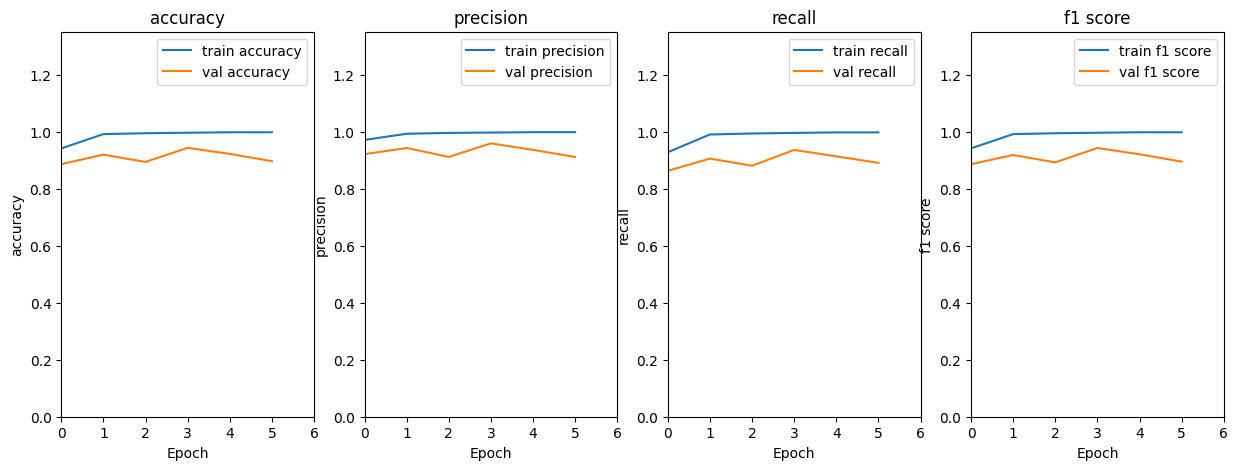

In [63]:
# Depending on the model, load corresponding json of metrics and history
if test_model == convnet3:
    with open(os.path.join('temp', 'convnet3_adam_categorical_crossentropy_lr0.001_mo9e-06_rs9964', 'trainhistory.json'), 'r') as f:
        history = json.load(f)
elif test_model == vgg:
    with open(os.path.join('temp', 'vgg_adam_categorical_crossentropy_lr0.001_mo9e-06_rs132', 'trainhistory.json'), 'r') as f:
        history = json.load(f)
elif test_model == vgg_best:
    with open(os.path.join('temp', 'vgg_adam_categorical_crossentropy_lr0.0001_mo9e-06_rs150', 'trainhistory.json'), 'r') as f:
        history = json.load(f)

def plot_metric(ax, metric_name: str, train_metric, val_metric):
    '''
    Function to plot the training and validation metric.
    '''
    # Source on how I figured out how to do this: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
    ax.plot(train_metric, label=f'train {metric_name}')
    ax.plot(val_metric, label=f'val {metric_name}')
    ax.set_title(metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_name)
    ax.legend()

    # set the x-axis limit to the length of the training
    ax.set_xlim([0, len(train_metric)])
    
    # set according to the highest metric line.
    ax.set_ylim([0, 1.35])

# Plot the training history
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

# plot all metrics
plot_metric(ax[0], 'accuracy', history['accuracy'], history['val_accuracy'])
plot_metric(ax[1], 'precision', history['precision'], history['val_precision'])
plot_metric(ax[2], 'recall', history['recall'], history['val_recall'])
plot_metric(ax[3], 'f1 score', history['f1_score'], history['val_f1_score'])
plt.show()

It appears it hardly took many epochs at all to train it. Note that the convnet3 and vgg model tend to overfit! Look at the gap between train and validation lines! This is an indication that we need to use greater dropout and other model regularization, data augmentation, or model simplification techniques. Our models generally have a slightly higher precision than recall in the initial epochs for validation. It appears that our classifier was having a more challenging time identifying positive cases (recall) early on, but among the cases it is identifying (precision), it is doing slightly better. Perhaps in the future, we will pay more attention to recall when considering our model design and training.

### **C. Confusion Matrix**

Next we will take 100 (for the sake of not iterating over every single validation image) of the batches from the shuffled dataset and plot a confusion matrix. While this is not perfectly equivalent to the entire split set, it is effectively close enough if we sample enough batches. In our particular classification problem, a confusion matrix is a very nice way of understanding what kinds of errors our model typically makes. Afterall, while some ASL letters are very distinct, such as the three vertical edges of a "W", others are hard to tell apart even for a human.

**NOTE**: feel free to change the number of batches used below.

In [64]:
num_batches_to_test = 100

We will use the following function, which gives us the desired confusion matrix:

In [65]:
def make_cf(num_batches_to_test: int, val_dataset, model):
    y_true = []
    y_pred = []

    # Loop over the validation dataset 
    for _ in range(num_batches_to_test):

        # Get the next batch of images and labels
        images, labels = next(val_dataset)

        # Make predictions
        prediction = model.predict(images)

        # Get the index of the highest softmax probability
        predicted_class = np.argmax(prediction, axis=1)

        # Append target and predicted labels
        y_true.append(np.argmax(labels, axis=1))
        y_pred.append(predicted_class)

    # Convert lists to numpy arrays
    y_true = np.concatenate(y_true)

    # smoosh 2d into 1d array for y_pred
    y_pred = np.array(y_pred).flatten()

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    return conf_matrix

conf_matrix = make_cf(num_batches_to_test, val_dataset, model)

1/1 [==============================] - 0s 15ms/step


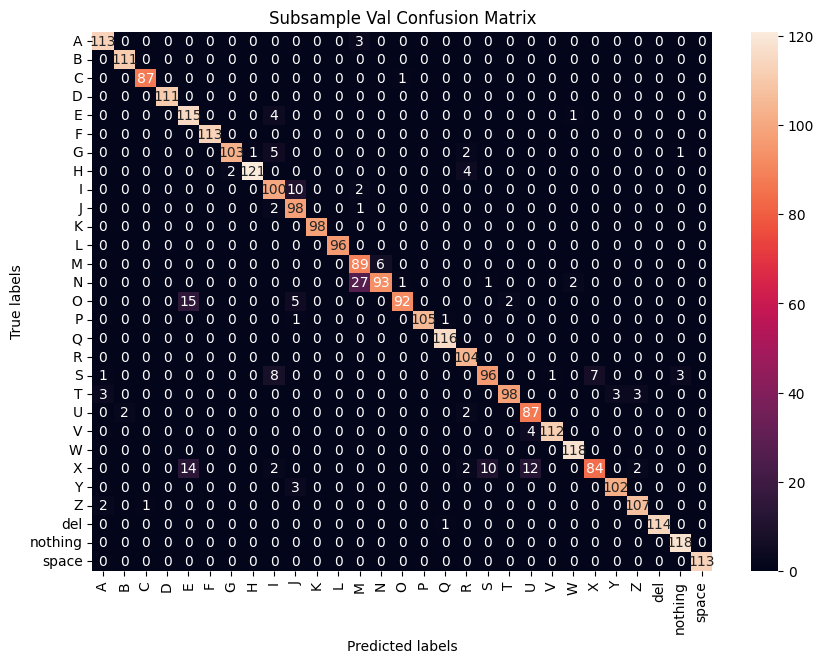

In [66]:
# Documentation source: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')

# Other plot info
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Subsample Val Confusion Matrix')

# convert class names to labels
plt.xticks(ticks=np.arange(29) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(29) + 0.5, labels=class_names, rotation=0)
plt.show()

Interesting! For Vgg(32x32x3 and 50x50x3) and convnet3, note that our models make very specific mistakes. Looking at the image below, it is quite obvious that our model seems to generally confuse letters that conform to the same hand shape (in vgg 32x32x3 at least: "M" vs "N", "K" vs "V", etc...). 


<div style="text-align: center;">
<div>
    <img src="figures\Sign_alphabet_chart_abc.jpg" alt="Alphabet" width="800" height="600"/> 
</div>
<div>
    <a href="https://www.lingvano.com/asl/blog/sign-language-alphabet/">(ASL alphabet)</a>
</div>
</div>

### **D. Example Prediction**

Now that we have a sense of our model's individual strengths and weaknesses on certain class predictions, we can test out how well our model generalizes to unseen data. Feel free to test out any letter!

**NOTE**: feel free to modify 'letter':

In [67]:
letter = 'C'

1/1 [==============================] - 1s 576ms/step
Top 5 classes: ['C', 'Q', 'D', 'Z', 'O']
Predicted class: 2 with probability 1.0
Actual class: 2 with probability 1.0


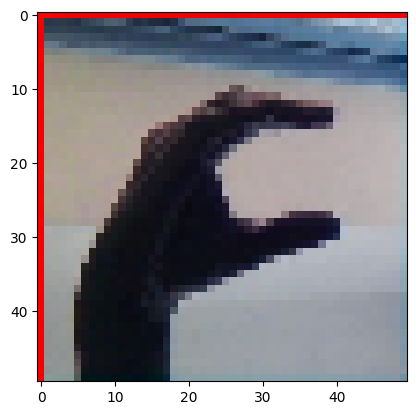

In [68]:
# retrieve the label. Fine since letters are unique here.
label = class_names.index(letter)

test_img = cv2.imread(f'data/asl_alphabet_test/asl_alphabet_test/{letter}_test.jpg')

# resize the image and preprocess it.
test_img = cv2.resize(test_img, img_size, interpolation=cv2.INTER_NEAREST)

# rescale and expand the dimensions.
test_img = test_img / 255.0

# Documentation source: https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html
test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)

# Argmax to get the predicted class from the multiple softmax probabilities.
predicted_class = np.argmax(prediction)

# top 5 predictions: argsort for 5 highest probabilities and reverse to get highest first.
top_5 = np.argsort(prediction[0])[-5:][::-1]
print(f"Top 5 classes: {[class_names[i] for i in top_5]}")
print(f"Predicted class: {predicted_class} with probability {str(round(prediction[0][predicted_class], ndigits=4))}")
print(f"Actual class: {label} with probability {str(round(prediction[0][label], ndigits=4))}")

# plot the image (squeeze it to remove the batch dimension)
plt.imshow(test_img.squeeze())

Generally what we can observe is that if a given letter is not properly predicted, it can be typically found in the top 3 highest probabilities. Even when predicted correctly we find very similar look letters with high probabilities together.

## **6 - Feature Map for Layers**

### **A. Feature Maps (_please use convnet3 - not implemented for vgg_)**

So far we have gained a shallow intuition of _why_ our model behaves the way it does. Perhaps a more relevant question is _how_. _How_ is it coming to the predictions that we observe?

In the following section we perform extraction of our feature maps to see what exactly our model is picking up on in our data. Why would we care to do this anyway?

1) Model explainability is of utmost importance. We often talk about deep learning as a kind of black box approach in machine learning. By trying to understand what our model learns, we build a healthier level of trust (or skepticism) in our model's ability to perform the classification we expect.

2) We are able to better modify our model or change things about our training to have it best learn from the data. We can check whether our model is actually learning anything meaningful!

3) We gain a greater appreciation for the data and problem at hand!

**NOTE**: again, feel free to choose a letter below.

In [69]:
letter = 'C'

1/1 [==============================] - 0s 107ms/step


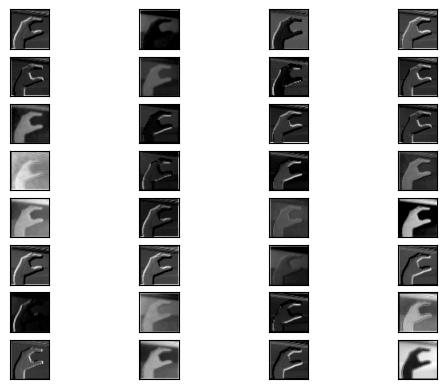

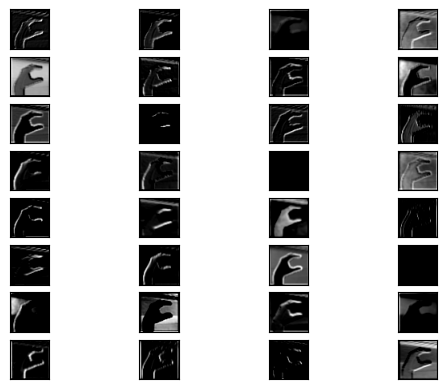

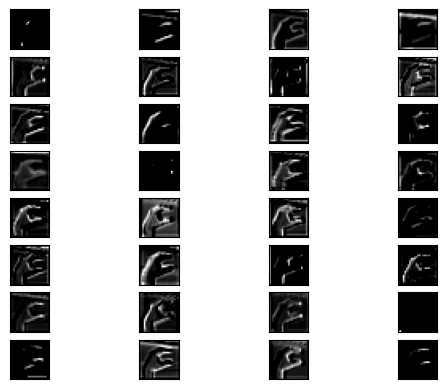

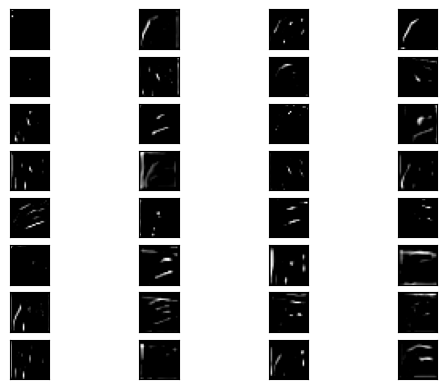

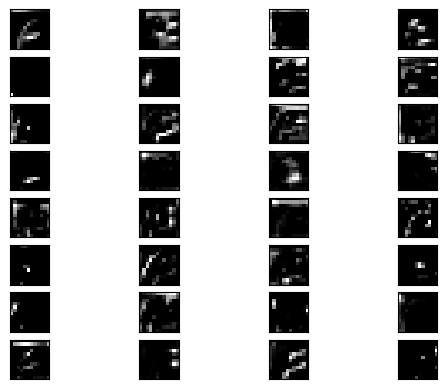

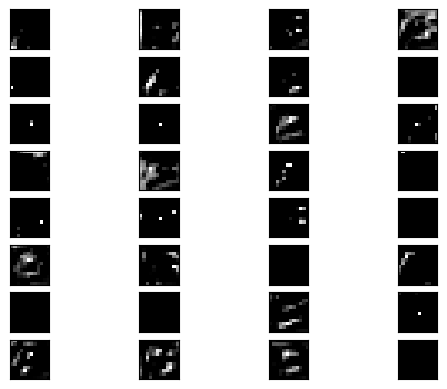

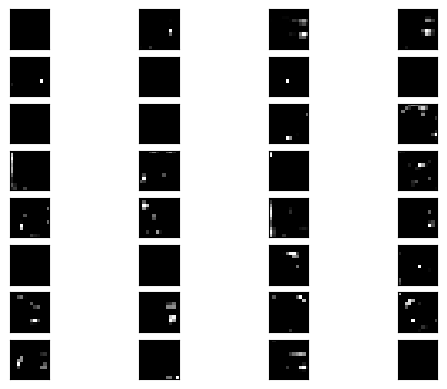

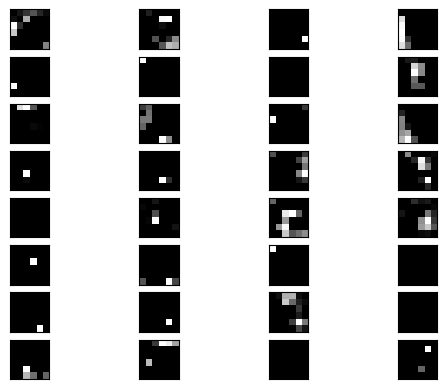

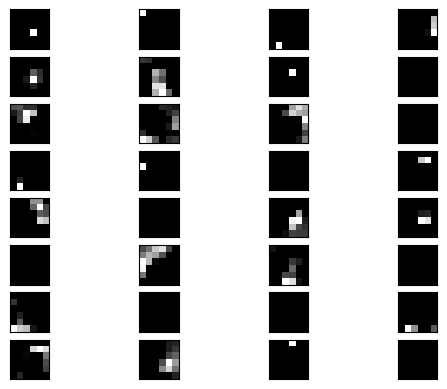

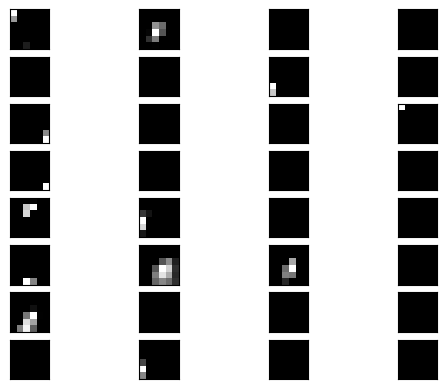

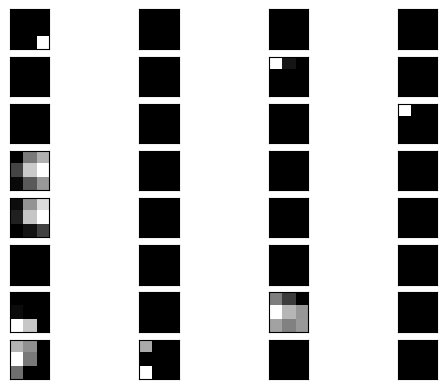

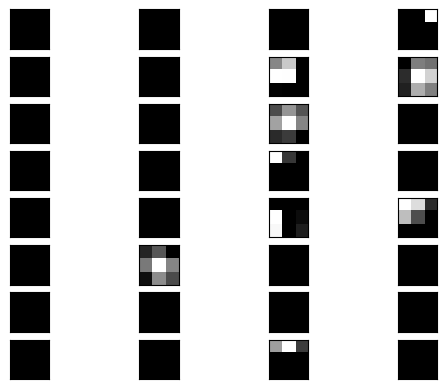

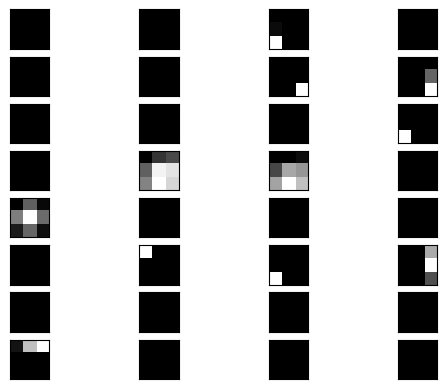

In [70]:
def getFeatureMap(model, img, img_size=(50, 50)):
    '''
    Function to get the feature maps of the convolutional layers of a model.
    I use this rerference when refactoring our code to get the feature maps: https://www.kaggle.com/code/sanidhyajadaun/extraction-of-feature-maps-on-mnist-dataset
    '''
    layer_ix = []
    for layer in model.layers:

        # We only want the convolutional layers feature maps
        if 'conv' not in layer.name:
            continue

        # append the index of the layer
        layer_ix.append(model.layers.index(layer))

    # redefine model to output right after the first hidden layer
    # new_model = Model(inputs=cur_model.inputs, outputs=cur_model.layers[11].output)
    outputs = [model.layers[i].output for i in layer_ix]
    new_model = Model(inputs=model.inputs, outputs=outputs)

    # resize the image and preprocess it.
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_NEAREST)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = np.expand_dims(img, axis=0)   

    feature_maps = new_model.predict(img)
    for fmap in feature_maps:
        ix = 1
        for _ in range(8):
            for _ in range(4):
                # specify subplot and turn of axis
                ax = plt.subplot(8, 4, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
                ix += 1
        # show the figure
        plt.show()
    return

test_featuremap_img = cv2.imread(f'data/asl_alphabet_test/asl_alphabet_test/{letter}_test.jpg')
getFeatureMap(model, test_featuremap_img, img_size)

## **7 - Try It!**

We have provided a demo.py file you can run with `python demo.py`. It has not been optimized yet, but it still works (albeit the classification is not the best in this circumstance due to the data not being entirely representative of situations in the wild).

**NOTE**: PLEASE NOTE THAT demo.py FILE LARGLEY NOT OUR OWN DEMO FILE. WE ADAPT IT FROM [HERE](https://github.com/cansik/yolo-hand-detection/blob/master/yolo.py) AND PLUG IN OUR OWN CLASSIFIER. THE CORRESPONDING YOLO WEIGHTS IN ./temp/ ARE NOT OUR OWN. CREDIT TO Florian Bruggisser, djthegr8 DJ, and roachsinai RoachZhao.

## **8 - References**

_All of the following references can be found individually in code or at relevant places of the notebook:_

1) [Numpy documentation](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) on expanding image dimensions - especially at inference time for us.
2) [Seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for figuring out how to make beautiful confusion matrices.
3) [matplotlib documentation](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html) for figuring out how to make nice metric visualizations.
4) [Stack Overflow thread](https://stackoverflow.com/questions/59356410/tensorflow-2-0-build-function) for figuring out why my model wouldn't actually load the weights until it was called.
5) [A refresher on convolution](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) that a re-read when trying to come up with a model.
6) [Medium article](https://lekhuyen.medium.com/an-overview-of-vgg16-and-nin-models-96e4bf398484) where I source VGG16 photo from and a better understanding of its architecture.
7) [ASL alphabet](https://www.lingvano.com/asl/blog/sign-language-alphabet/) where I source the alphabet image to understand my predictions in context.
8) [Stack Overflow thread](https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator) on understanding how to correctly perform splittings with a a datagenerator such that there is no leakage (there was previously).
9) [Stack Overflow](https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function) for understanding what from_logits does in categorical_cross_entropy (really just about the final softmax or not in the model).
10) [B.U. School of Public Health](https://www.bu.edu/sph/news/articles/2018/healthcare-language-barriers-affect-deaf-people-too/) is where I sourced some background info on the classification problem statement. 
11) [Kaggle page](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) is where the dataset comes from.
12) [R.I.](https://cdhh.ri.gov/information-referral/american-sign-language.php) is where I also got more background research info in problem statement.
13) [N.I.H.](https://www.nidcd.nih.gov/health/american-sign-language) for more background research info in the problem statement.
14) [Stack Overflow](https://stackoverflow.com/questions/59353009/list-of-metrics-that-can-be-passed-to-tf-keras-model-compile) for understanding how and which metrics I can effectively pass to the model.compile() (+ tensorflow_addons).
15) [GitHub repo](https://github.com/cansik/yolo-hand-detection/blob/master/yolo.py) we source the demo file and YOLO model from when plugging in our classifier to a real-world context.
16) [Kaggle notebook](https://www.kaggle.com/code/sanidhyajadaun/extraction-of-feature-maps-on-mnist-dataset) we use as a reference in refactoring our feature extraction code to generalize to all kinds of models and not just convnet4.
17) [A blog post](https://www.jeremyjordan.me/convnet-architectures/) we briefly mention when referencing model architectures.
18) We use ChatGPT to refactor some of our existing code (especially for the models and compatibility with feature map extraction). Underlying logic is the same. We also use it for generating html formatted for displaying in our notebooks, and figures explaining our repository structure in notebooks and README.
